In [1]:
import networkx as nx
import osmnx as ox
from matplotlib.collections import LineCollection
import matplotlib.pyplot as plt
from IPython.display import IFrame
from operator import attrgetter
import time
ox.config(log_console=True, use_cache=True)
import numpy 
import sys
from problem import PriorityQueue
numpy.set_printoptions(threshold=sys.maxsize)

In [2]:
place = 'Piedmont, California, USA'
G = ox.graph_from_place(place, network_type='drive_service')
G = ox.project_graph(G)
## to be deleted
G = ox.graph_from_place(place, network_type='drive_service')
graph_map = ox.plot_graph_folium(G, popup_attribute='name', edge_width=2)


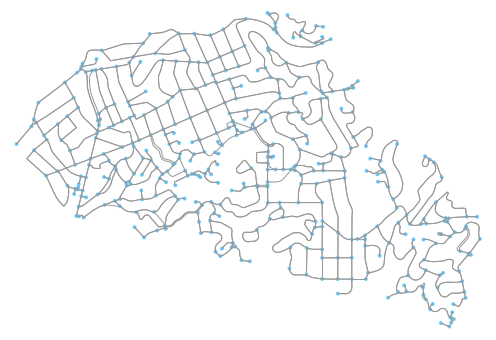

In [3]:
fig, ax = ox.plot_graph(G)

In [4]:
class Node:
    # TODO : __slots__ not __dict___ -- Optimization
    def __init__(self, node, osmid, distance = 0, parent = None):
        self.node = node
        self.distance = distance
        self.parent = parent
        self.osmid = osmid
        
        # I need this for dijkstra
        self.from_origin = self.distance_from_origin()
    
    # TODO : list comprehension -- Optimization
    def expand(self):
        children = [Node(G[child], child, distance = self.node[child][0]['length'], parent = self) \
                         for child in self.node]
        return children
    
    def path(self):
        node = self
        path = []
        while node:
            path.append(node.osmid)
            node = node.parent
        return path[::-1]
    
    # TODO : better algorithm -- Optimization
    # I don't need to go to the parent to get the distance
    # every time I invoke the function
    
    def distance_from_origin(self):
        meters = 0
        node = self
        while node:
            meters += node.distance
            node = node.parent
        return meters

    def __eq__(self, other):
        try:
            return self.osmid == other.osmid
        except:
            return self.osmid == other
            
    
    def __hash__(self):
        return hash(self.osmid)

In [5]:
node_Xs = [float(x) for _, x in G.nodes(data='x')]
node_Ys = [float(y) for _, y in G.nodes(data='y')]
edges = ox.graph_to_gdfs(G, nodes=False, fill_edge_geometry=True)
west, south, east, north = edges.total_bounds
len(G)

413

In [22]:
# tuple (source, destination, distance)
Edges = PriorityQueue('min', lambda edge: edge[2])   

In [23]:
for source, destination, data in G.edges(keys=False, data=True):
    Edges.append((source, destination, data['length']))
len(Edges)

1076

In [24]:
# disjoint set for the edges
nodes_set = {}
for i in Edges.heap:
    nodes_set[i[1][0]] = -1
    nodes_set[i[1][1]] = -1

In [25]:
def find_parent(node):
    r = node
    while nodes_set[r] >= 0:
        r = nodes_set[r]
    return r

In [27]:
def union_parent(node1, node2):
    parents = nodes_set[node1] + nodes_set[node2]
    print(node1, " |-|-|-| ", node2)
    # so we don't have a deep forest in our set
    if nodes_set[node1] > nodes_set[node2]:
        nodes_set[node1] = node2
        nodes_set[node2] = parents
    else:
        nodes_set[node2] = node1
        nodes_set[node1] = parents
    print(nodes_set[node1]," >>> ", nodes_set[node2])
    print("---------------------------------------------")

In [28]:
Forest = set()
Size = 0
j = 0
m = len(Edges)
n = len(G.nodes)
while Size < n and j < m:
    j += 1
    # the shortest edge till this point
    edge = Edges.pop()
    node1 = edge[0]
    node2 = edge[1]
    parent1 = find_parent(node1)
    parent2 = find_parent(node2)
    if parent1 != parent2:
        Forest.add(edge)
        Size += 1
        union_parent(node1, node2)

2890584258  |-|-|-|  5477686670
-2  >>>  2890584258
---------------------------------------------
53073689  |-|-|-|  5484284278
-2  >>>  53073689
---------------------------------------------
53082625  |-|-|-|  5484284273
-2  >>>  53082625
---------------------------------------------
7529529087  |-|-|-|  7529529089
-2  >>>  7529529087
---------------------------------------------
53025057  |-|-|-|  3164026067
-2  >>>  53025057
---------------------------------------------
53021742  |-|-|-|  683050219
-2  >>>  53021742
---------------------------------------------
53021750  |-|-|-|  683050221
-2  >>>  53021750
---------------------------------------------
683050120  |-|-|-|  2286923086
-2  >>>  683050120
---------------------------------------------
53108990  |-|-|-|  53118374
-2  >>>  53108990
---------------------------------------------
256338812  |-|-|-|  256338813
-2  >>>  256338812
---------------------------------------------
53041437  |-|-|-|  5477686667
-2  >>>  53041437
-----

KeyError: 53125971